In [1]:
from IPython.display import display, HTML
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

import numpy as np
import warnings


from datetime import datetime
import glob
import io, os , sys, types
import tabulate
import copy

import random

import matplotlib.pyplot as plt
%matplotlib inline
import itertools

from sklearn.model_selection import train_test_split
from sklearn import linear_model
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB 
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.ensemble import RandomForestClassifier
import pydotplus

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

from helper_functions import *

import seaborn as sns
sns.set(color_codes=True)

fontsz = 12

# ROC Curve and Cutoff Analysis:
# https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/One_ROC_Curve_and_Cutoff_Analysis.pdf

In [2]:
# load the dataset
fname_germancredit = r'dataset/German.Credit.csv'
data_raw = pd.read_csv(fname_germancredit)

In [3]:
data_raw.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [4]:
col_target = 'class'
cols_numeric = list(data_raw.describe().columns.values)
cols_categoric = list(set(data_raw.columns.values) - set(cols_numeric) - set([col_target]))

In [5]:
cols_categoric

['other_parties',
 'own_telephone',
 'property_magnitude',
 'savings_status',
 'credit_history',
 'job',
 'account_balance',
 'other_payment_plans',
 'purpose',
 'housing',
 'foreign',
 'employment',
 'personal_status']

In [6]:
# Contingency table
pd.crosstab(data_raw['class'], data_raw['account_balance'],  margins=True)

account_balance,'0<=X<200','<0','>=200','no account',All
class,,,,,
bad,105,135,14,46,300
good,164,139,49,348,700
All,269,274,63,394,1000


In [7]:
# Contingency table, ratios. Rows add-up to 100%
pd.crosstab(data_raw['class'], data_raw['account_balance'],  margins=False, normalize='index')

account_balance,'0<=X<200','<0','>=200','no account'
class,,,,
bad,0.350000,0.450000,0.046667,0.153333
good,0.234286,0.198571,0.070000,0.497143


In [8]:
# Contingency table, ratios. Columns add-up to 100%
pd.crosstab(data_raw['class'], data_raw['account_balance'],  margins=False, normalize='columns')

account_balance,'0<=X<200','<0','>=200','no account'
class,,,,
bad,0.390335,0.492701,0.222222,0.116751
good,0.609665,0.507299,0.777778,0.883249


In [9]:
contingency = pd.crosstab(data_raw['class'], data_raw['account_balance'])
c, pval, dof, expected = chi2_contingency(contingency)
print("p-value:",pval, '\t variable:', 'account_balance')

p-value: 1.21890207229e-26 	 variable: account_balance


In [10]:
for col in cols_categoric:
    contingency = pd.crosstab(data_raw['class'], data_raw[col])
    c, pval, dof, expected = chi2_contingency(contingency)
    print("p-value:",pval, '\t variable:', col)

p-value: 0.0360559540272 	 variable: other_parties
p-value: 0.278876154304 	 variable: own_telephone
p-value: 2.85844157333e-05 	 variable: property_magnitude
p-value: 2.76121423857e-07 	 variable: savings_status
p-value: 1.27918729568e-12 	 variable: credit_history
p-value: 0.596581591884 	 variable: job
p-value: 1.21890207229e-26 	 variable: account_balance
p-value: 0.00162931781865 	 variable: other_payment_plans
p-value: 0.000115749100797 	 variable: purpose
p-value: 0.000111674653746 	 variable: housing
p-value: 0.0158307549029 	 variable: foreign
p-value: 0.00104545234914 	 variable: employment
p-value: 0.0222380054693 	 variable: personal_status


#### Descriptive Statistics for Numerical Predictors

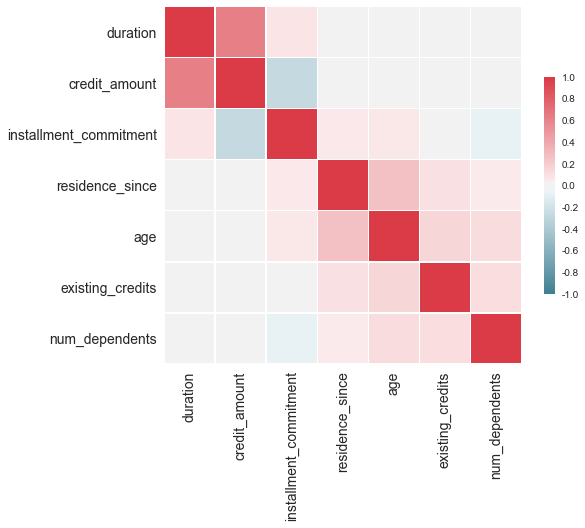

In [11]:
# Correlation between numeric variables
data_numeric = data_raw[cols_numeric].copy(deep=True)
corr_mat = data_numeric.corr(method='pearson')
cbar_ticks =np.linspace(-1,1,11)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=[8,8])
plt.xticks(fontsize=fontsz+2)
plt.yticks(fontsize=fontsz+2)
ax = sns.heatmap(corr_mat, cmap=cmap, vmin=-1, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5})
cbar = ax.collections[0].colorbar
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticks)
plt.show()

In [12]:
print (corr_mat)

                        duration  credit_amount  installment_commitment  residence_since       age  existing_credits  num_dependents
duration                1.000000       0.624984                0.074749         0.034067 -0.036136         -0.011284       -0.023834
credit_amount           0.624984       1.000000               -0.271316         0.028926  0.032716          0.020795        0.017142
installment_commitment  0.074749      -0.271316                1.000000         0.049302  0.058266          0.021669       -0.071207
residence_since         0.034067       0.028926                0.049302         1.000000  0.266419          0.089625        0.042643
age                    -0.036136       0.032716                0.058266         0.266419  1.000000          0.149254        0.118201
existing_credits       -0.011284       0.020795                0.021669         0.089625  0.149254          1.000000        0.109667
num_dependents         -0.023834       0.017142               -0.0712

#### Histograms 

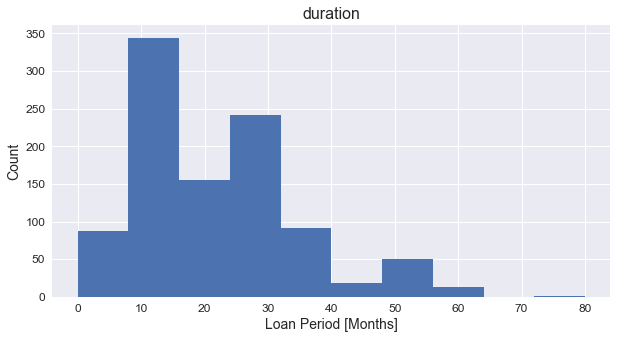

In [13]:
brksCredits = np.linspace(0,80,11) # Bins for a nice looking histogram
plt.figure(figsize=(10,5))
plt.hist(data_raw['duration'], bins=brksCredits)
plt.title('duration', fontsize=fontsz+4)
plt.xlabel('Loan Period [Months]', fontsize=fontsz+2)
plt.ylabel('Count', fontsize=fontsz+2)
plt.xticks(fontsize=fontsz)
plt.yticks(fontsize=fontsz)
plt.show()

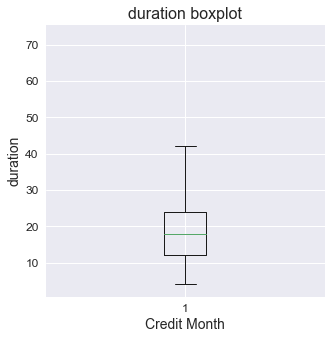

In [14]:
plt.figure(figsize=(5,5))
plt.boxplot(data_raw['duration']) 
plt.title('duration boxplot', fontsize=fontsz+4)
plt.xlabel('Credit Month', fontsize=fontsz+2) 
plt.ylabel('duration', fontsize=fontsz+2)
plt.xticks(fontsize=fontsz)
plt.yticks(fontsize=fontsz)
plt.show()

#### Preprocessing
Dummy variables

In [15]:
print ("Number of columns before dummy-variables:\t", len(data_raw.columns.values))
for i in cols_categoric:
    dummy_ranks = pd.get_dummies(data_raw[i], prefix=i)
    data_raw = data_raw.join(dummy_ranks)
    # dropping the original categoric column (not needed - it was replaced by dummy columns)
    data_raw = data_raw.drop(i, 1) 
    
# all feature, numeric, and categoric (now dummified)
cols_features = list(set(data_raw.columns.values) - set([col_target])) 
print ("Number of columns after dummy-variables:\t", len(data_raw.columns.values))

Number of columns before dummy-variables:	 21
Number of columns after dummy-variables:	 62


In [16]:
# Replacing calss variable with numeric values (for convinience)
data_raw['class'].replace('bad', 0, inplace=True)
data_raw['class'].replace('good', 1, inplace=True)
data_raw['class'] = pd.to_numeric(data_raw['class'])

In [17]:
# Random seed
seed = 1017
random.seed(seed)
frac_train = 0.8 # 80% of the data is used for training
X_train, X_test, y_train, y_test = \
    train_test_split(data_raw[cols_features], data_raw[col_target], test_size=(1-frac_train), random_state=seed)
    
train_b = sum(y_train == 0)
train_g = sum(y_train == 1)
test_b = sum(y_test == 0)
test_g = sum(y_test == 1)
print ("Class ratios between each set:")
print ("Trainset")
print ("\t\tNormal class (good):", 100*train_g/len(y_train), "%\t", "Target class (bad):", 100*train_b/len(y_train),"%")
print ("Testset")
print ("\t\tNormal class (good):", 100*test_g/len(y_test), "%\t", "Target class (bad):", 100*test_b/len(y_test),"%")

Class ratios between each set:
Trainset
		Normal class (good): 71.25 %	 Target class (bad): 28.75 %
Testset
		Normal class (good): 65.0 %	 Target class (bad): 35.0 %


In [18]:
# Set Misclassification loss weights
c_tn = 0 # weight of true-negative
c_tp = 0 # weight of true-positive
c_fn = 1 # weight of false negative
c_fp = 5 # weight of false positive

### Logistic Regression Model
More about Logistic Regression examples in python can be found here:<br>
http://blog.yhat.com/posts/logistic-regression-python-rodeo.html

In [19]:
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
mse = np.mean(y_train - model.predict(X_train)) ** 2
print ("Mean Square Error: ", mse)

Mean Square Error:  0.007225


In [21]:
model_coefficients = model.coef_[0]
df_lgm_coeffs = pd.DataFrame(data=model_coefficients, index=cols_features, columns=['LGM_coeff'])
# sort by coefficients absolute value
df_lgm_coeffs = df_lgm_coeffs.reindex(df_lgm_coeffs['LGM_coeff'].abs().sort_values(ascending=False).index)
display(df_lgm_coeffs)

,LGM_coeff
purpose_'used car',1.031194
account_balance_'no account',0.970004
credit_history_'critical/other existing credit',0.851892
foreign_no,0.711346
other_payment_plans_none,0.671087
other_parties_guarantor,0.662352
purpose_'new car',-0.647875
employment_'4<=X<7',0.606323
account_balance_'<0',-0.596525
purpose_education,-0.582856


In [22]:
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)[:,1]

Area-Under-Curve: 0.8055


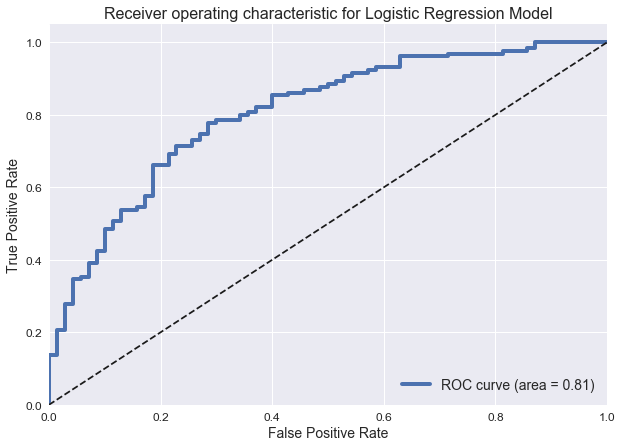

In [23]:
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), predicted_prob)
auc = metrics.auc(fpr,tpr)
print ("Area-Under-Curve:", round(auc,4))
# plot_ROC() is defined in helper_functions.py
plot_ROC(fpr,tpr, fontsz, 'Receiver operating characteristic for Logistic Regression Model') 

In [24]:
# finding the optimal values using the TRAIN-SET
train_predicted_prob = model.predict_proba(X_train)[:,1]
loss_matrix = calculate_loss(train_predicted_prob, y_train, c_fn, c_fp, c_tp, c_tn) 
# finding optimal threshold:
opt_thr = list(loss_matrix[loss_matrix['loss'] == loss_matrix['loss'].min()]['prediction'])[0]
print("Optimal threshold at:\t",round(opt_thr,5))
print("Model Loss:", loss_matrix['loss'].min())
loss = loss_matrix['loss'].min()
predicted_prob_opt = copy.deepcopy(predicted_prob)
predicted_prob_opt[predicted_prob_opt >  opt_thr] = 1
predicted_prob_opt[predicted_prob_opt <= opt_thr] = 0

Optimal threshold at:	 0.76212
Model Loss: 354


In [25]:
def_cfm = metrics.confusion_matrix(y_test, predicted) # default confusion matrix, default threshold = 0.5
opt_cfm = metrics.confusion_matrix(y_test, predicted_prob_opt) # optimal threshold

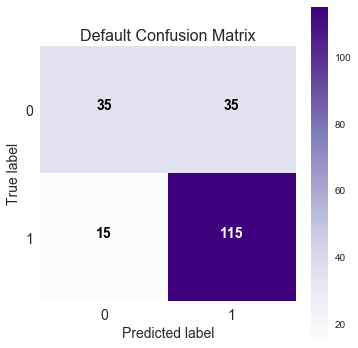

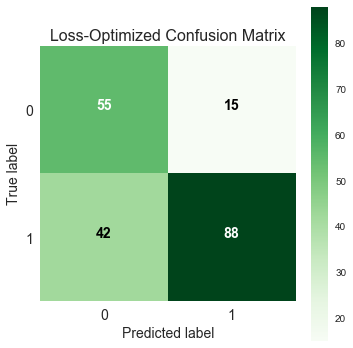

In [26]:
plot_confusion_matrix(def_cfm,['bad', 'good'], "Default Confusion Matrix", 0)
plot_confusion_matrix(opt_cfm,['bad', 'good'], "Loss-Optimized Confusion Matrix", 1)
plt.show()

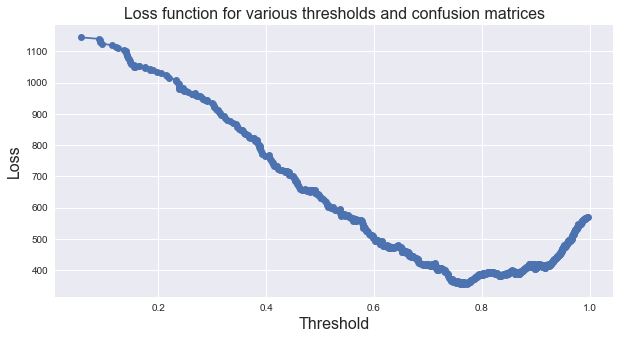

In [27]:
plt.figure(figsize=(10,5), facecolor='white')
plt.plot(loss_matrix['prediction'], loss_matrix['loss'], 'o-')
plt.title('Loss function for various thresholds and confusion matrices', fontsize=fontsz+4)
plt.xlabel('Threshold', fontsize=fontsz+4)
plt.ylabel('Loss', fontsize=fontsz+4)
plt.show()

## Naive Bayes Model

In [28]:
gnb = BernoulliNB()
model = gnb.fit(X_train, y_train)
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)[:, 1]

In [29]:
model_coefficients = model.coef_[0]
df_coeffs = pd.DataFrame(data=model_coefficients, index=cols_features, columns=['coeff'])
# sort by coefficients absolute value
df_coeffs = df_coeffs.reindex(df_coeffs['coeff'].abs().sort_values(ascending=False).index)
display(df_coeffs)

,coeff
purpose_retraining,-4.269697
purpose_other,-4.269697
purpose_'domestic appliance',-4.269697
job_'unemp/unskilled non res',-3.864232
credit_history_'no credits/all paid',-3.710082
purpose_repairs,-3.641089
credit_history_'all paid',-3.404700
other_parties_'co applicant',-3.258097
other_payment_plans_stores,-3.258097
personal_status_'male div/sep',-3.130263


Area-Under-Curve: 0.8127


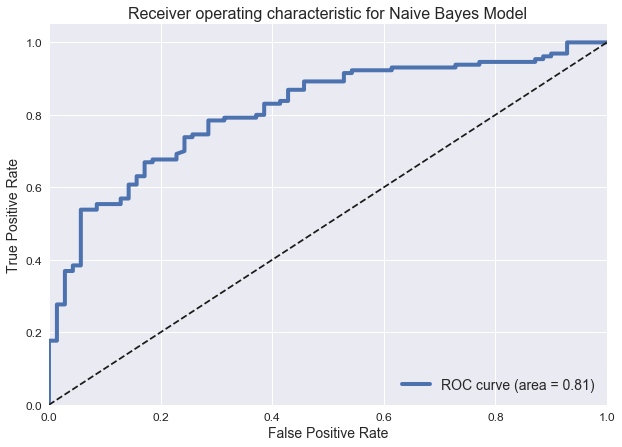

In [30]:
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), predicted_prob)
auc = metrics.auc(fpr,tpr)
print ("Area-Under-Curve:", round(auc,4))
plot_ROC(fpr,tpr, fontsz, 'Receiver operating characteristic for Naive Bayes Model') 

In [31]:
# finding the optimal values using the TRAIN-SET
train_predicted_prob = model.predict_proba(X_train)[:,1]
loss_matrix = calculate_loss(train_predicted_prob, y_train, c_fn, c_fp, c_tp, c_tn) 
# finding optimal threshold:
opt_thr = list(loss_matrix[loss_matrix['loss'] == loss_matrix['loss'].min()]['prediction'])[0]
print("Optimal threshold at:\t",round(opt_thr,5))
loss = loss_matrix['loss'].min()
print("Model Loss:", loss)
predicted_prob_opt = copy.deepcopy(predicted_prob)
predicted_prob_opt[predicted_prob_opt >  opt_thr] = 1
predicted_prob_opt[predicted_prob_opt <= opt_thr] = 0

Optimal threshold at:	 0.89736
Model Loss: 395


In [32]:
def_cfm = metrics.confusion_matrix(y_test, predicted) 
opt_cfm = metrics.confusion_matrix(y_test, predicted_prob_opt) # optimal threshold

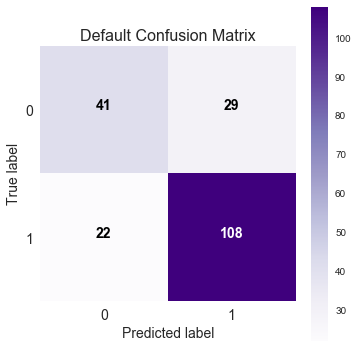

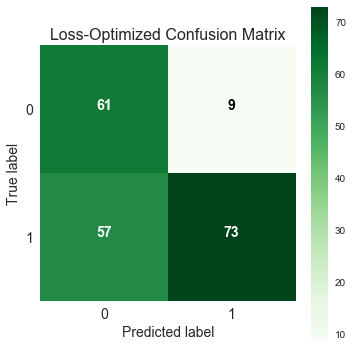

In [33]:
plot_confusion_matrix(def_cfm,['bad', 'good'], "Default Confusion Matrix", 0)
plot_confusion_matrix(opt_cfm,['bad', 'good'], "Loss-Optimized Confusion Matrix", 1)
plt.show()

## Decision Trees
Decision Trees is a recursive-repartitioning technique, which is used to recursively split the data in order to create nodes that are<br>
purer. A pure node is a node that consists of only 1-class of those existing in the data.<br>
In our context, a pure node would be composed of either all-"bad" or all-"good" classes.<br>
The advantages of DT is that it produces rules that are easy to follow, and human-readable, in contrast to other "black-box" algorithms, such as Random-Forest<br>
DTs however, are prone to overfitting, which is why we need to use some parameters to avoid such behavior.<br>
As with __Logistic Regression__, __DT__s also require categorical features to be dummified.<br>
1. Based on what we discussed, can you offer an intuition about why DTs tend to overfit?
2. [Advanced] Can you offer some ways to avoid overfitting?

In [34]:
md = 18                    # maximum tree depth
mf = len(cols_features)    # maximum number of features to consider
min_leaf = 10
criterion = 'entropy'
model = tree.DecisionTreeClassifier(max_depth=md, max_features=mf, criterion=criterion, 
                                    min_samples_leaf=min_leaf, random_state=seed)

clf = model.fit(X_train, y_train)
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)[:, 1]

In [35]:
importance = model.feature_importances_
df_importance = pd.DataFrame(data=importance, index=cols_features, columns=['importance'])
df_importance = df_importance[df_importance['importance'] != 0]
# sort by feature importance
df_importance = df_importance.reindex(df_importance['importance'].abs().sort_values(ascending=False).index)
display(df_importance)

,importance
account_balance_'no account',0.189165
duration,0.123844
credit_amount,0.102473
age,0.069504
property_magnitude_'real estate',0.063810
other_payment_plans_none,0.054990
purpose_radio/tv,0.039528
employment_'4<=X<7',0.035832
property_magnitude_car,0.034601
installment_commitment,0.028928


In [36]:
# Visualize the tree
write_Tree('dataset', clf, cols_features) # can be used only for small trees (<=4)

Area-Under-Curve: 0.7087


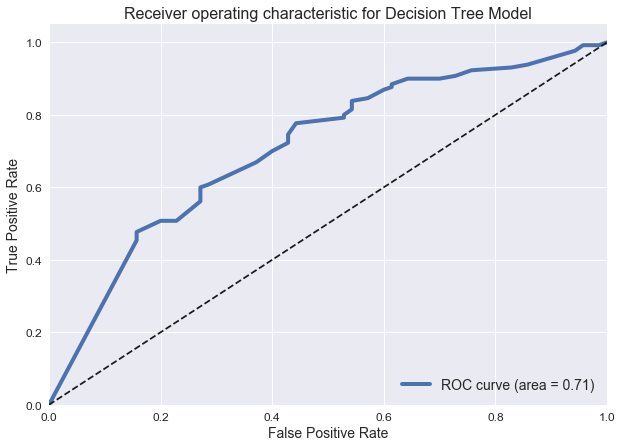

In [37]:
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), predicted_prob)
auc = metrics.auc(fpr,tpr)
print ("Area-Under-Curve:", round(auc,4))
plot_ROC(fpr,tpr, fontsz, "Receiver operating characteristic for Decision Tree Model") 

In [38]:
# finding the optimal values using the TRAIN-SET
train_predicted_prob = model.predict_proba(X_train)[:,1]
loss_matrix = calculate_loss(train_predicted_prob, y_train, c_fn, c_fp, c_tp, c_tn) 
# finding optimal threshold:
opt_thr = list(loss_matrix[loss_matrix['loss'] == loss_matrix['loss'].min()]['prediction'])[0]
print("Optimal threshold at:\t",round(opt_thr,5))
loss = loss_matrix['loss'].min()
print("Model Loss:", loss)
predicted_prob_opt = copy.deepcopy(predicted_prob)
predicted_prob_opt[predicted_prob_opt >  opt_thr] = 1
predicted_prob_opt[predicted_prob_opt <= opt_thr] = 0

Optimal threshold at:	 0.83333
Model Loss: 271


In [39]:
def_cfm = metrics.confusion_matrix(y_test, predicted) 
opt_cfm = metrics.confusion_matrix(y_test, predicted_prob_opt) # optimal threshold

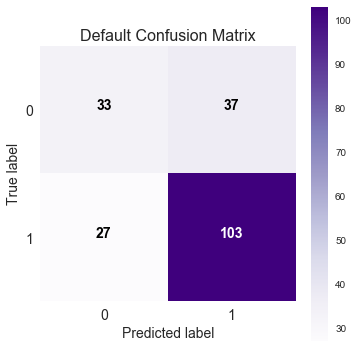

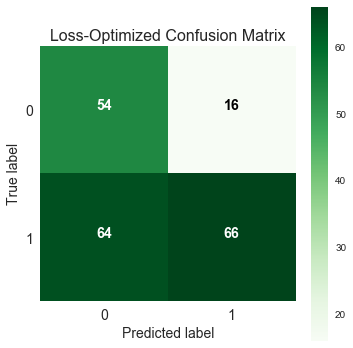

In [40]:
plot_confusion_matrix(def_cfm,['bad', 'good'], "Default Confusion Matrix", 0)
plot_confusion_matrix(opt_cfm,['bad', 'good'], "Loss-Optimized Confusion Matrix", 1)
plt.show()

## Random Forest
Random Forest is an ensemble learning classification method, which utilizes multiple decision-trees,<br>
and a voting mechanism in order to classify each sample.

In [41]:
model = RandomForestClassifier(max_depth=md, max_features=mf, 
                               criterion=criterion, min_samples_leaf = min_leaf, random_state=seed)
clf = model.fit(X_train, y_train)

In [42]:
importance = model.feature_importances_
df_importance = pd.DataFrame(data=[list(cols_features), list(importance)]).transpose()
df_importance.columns = ['feature', 'importance']
df_importance = df_importance[df_importance['importance'] != 0]
# sort by feature importance
df_importance = df_importance.reindex(df_importance['importance'].abs().sort_values(inplace=False, ascending=False).index)
display(df_importance)

,feature,importance
26,account_balance_'no account',0.185197
50,duration,0.140193
16,credit_amount,0.12524
25,age,0.0838345
45,other_payment_plans_none,0.0383443
54,credit_history_'critical/other existing credit',0.0322935
9,residence_since,0.031474
21,installment_commitment,0.0298959
39,property_magnitude_'real estate',0.0281022
46,savings_status_'<100',0.0236219


Area-Under-Curve: 0.7736


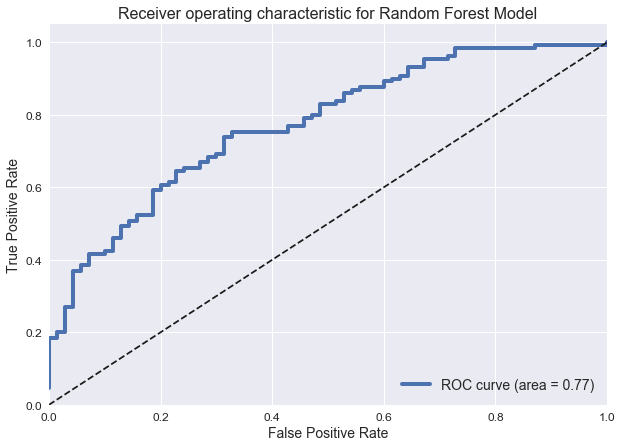

In [43]:
predicted = clf.predict(X_test)
predicted_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test), predicted_prob)
auc = metrics.auc(fpr,tpr)
print ("Area-Under-Curve:", round(auc,4))
plot_ROC(fpr,tpr, fontsz, "Receiver operating characteristic for Random Forest Model")

In [44]:
# finding the optimal values using the TRAIN-SET
train_predicted_prob = model.predict_proba(X_train)[:,1]
loss_matrix = calculate_loss(train_predicted_prob, y_train, c_fn, c_fp, c_tp, c_tn) 
# finding optimal threshold:
opt_thr = list(loss_matrix[loss_matrix['loss'] == loss_matrix['loss'].min()]['prediction'])[0]
print("Optimal threshold at:\t",round(opt_thr,5))
loss = loss_matrix['loss'].min()
print("Model Loss:", loss)
predicted_prob_opt = copy.deepcopy(predicted_prob)
predicted_prob_opt[predicted_prob_opt >  opt_thr] = 1
predicted_prob_opt[predicted_prob_opt <= opt_thr] = 0

Optimal threshold at:	 0.69322
Model Loss: 241


In [45]:
def_cfm = metrics.confusion_matrix(y_test, predicted) 
opt_cfm = metrics.confusion_matrix(y_test, predicted_prob_opt) # optimal threshold

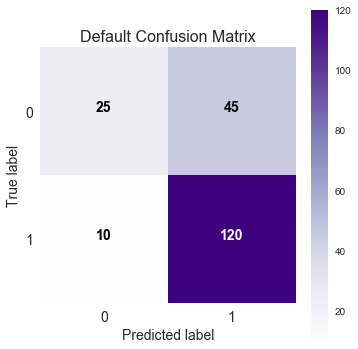

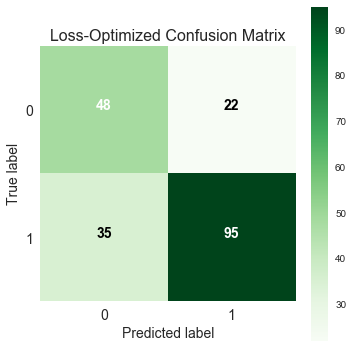

In [46]:
plot_confusion_matrix(def_cfm,['bad', 'good'], "Default Confusion Matrix", 0)
plot_confusion_matrix(opt_cfm,['bad', 'good'], "Loss-Optimized Confusion Matrix", 1)
plt.show()

In [ ]:
# model AUC, loss:
# Logistic Regression:    0.81, 354
# Naive Bayes:            0.81, 395
# Decision Tree:          0.71, 271
# Random Forest:          0.77, 241 